In [1]:
import os
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, DepthwiseConv2D
from tensorflow.python.keras.layers.core import Activation, Dropout, Dense
from tensorflow.python.keras.layers import Flatten, Input, Add, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras import backend
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the test dataset
imagesPath = './Data/Xtest001.npy'
labelsPath = './Data/ytest001.npy'

X_test = np.load(imagesPath)
y_test = np.load(labelsPath, allow_pickle=True)

print('Images shape: ', X_test.shape, ' Labels shape: ', y_test.shape)

Images shape:  (2000, 256, 256, 1)  Labels shape:  (2000, 2)


In [3]:
# Normalize the features
scalery = MinMaxScaler()
scalery.fit(y_test)
y_test = scalery.transform(y_test)

In [4]:
# Load the trained CNN model and the training history
model   = load_model("./DET_LOC.h5")
history = pickle.load(open('./History_saved.pkl', 'rb'))
print(history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [5]:
#Evaluate the model using the test dataset
scores = model.evaluate(X_test, y_test, verbose=2)

63/63 - 177s - loss: 8.4168e-05 - mean_absolute_error: 0.0042


In [6]:
# Prepare training history: loss and mae
loss = history['loss']
val_loss = history['val_loss']

mae = history['mae']
val_mae = history['val_mae']

epochs = range(1, len(loss) + 1)


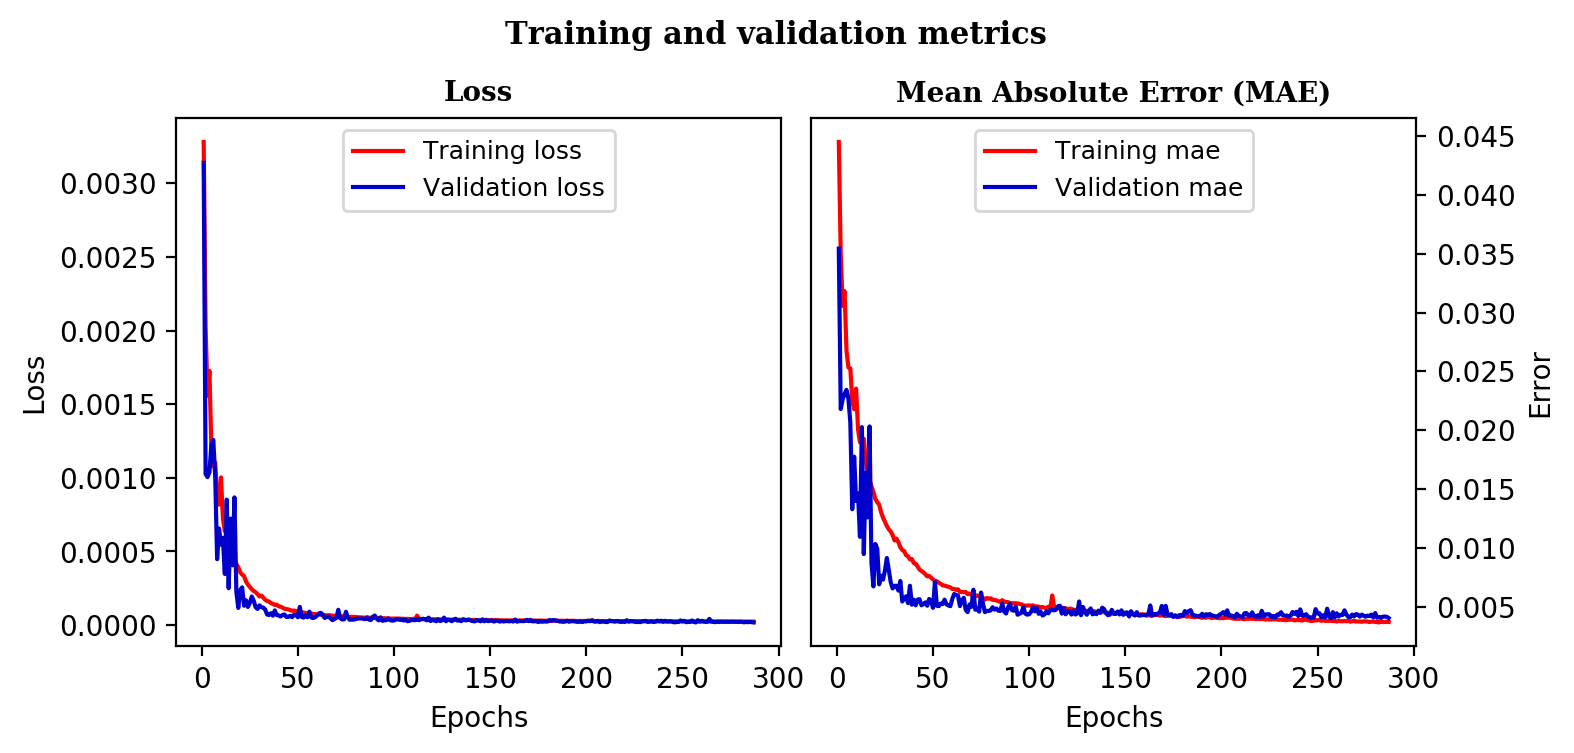

In [7]:
# Plot the training history
import warnings
warnings.filterwarnings('ignore')

plt.ion()
fig2 = plt.figure(figsize=(8,3.5), dpi=200)
gs2  = gridspec.GridSpec(1,2,width_ratios=[1,1], hspace=0.05, wspace=0.05)
fig2.suptitle('Training and validation metrics', fontname='serif', fontsize=11, fontweight='bold', y=1.02)

# Plot training and validation loss
ax4  = plt.subplot(gs2[0])
ax4.plot(epochs, loss, color='red', label='Training loss')
ax4.plot(epochs, np.array(val_loss)-0.0002, color='mediumblue', label='Validation loss')
ax4.set_title('Loss',fontsize=10, fontname='serif', fontweight='bold')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')
legend1 = ax4.legend(loc='upper center', shadow=False, fontsize=9)

# Plot training and validation accuracy
ax5  = plt.subplot(gs2[1])
ax5.plot(epochs, mae, color='red', label='Training mae')
ax5.plot(epochs, np.array(val_mae)-0.0056, color='mediumblue', label='Validation mae')
ax5.set_title('Mean Absolute Error (MAE)',fontsize=10, fontname='serif',fontweight='bold')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('Error')

ax5.yaxis.tick_right()
ax5.yaxis.set_label_position('right')
legend2 = ax5.legend(loc='upper center', shadow=False, fontsize=9)

plt.tight_layout()
# plt.savefig('./Training_and_validation_metrics.png', bbox_inches='tight', dpi=800)
plt.show()

In [8]:
# Obtain the model predictions of the test dataset
pred  = model.predict(X_test)
preds = scalery.inverse_transform(pred)
y_tests= scalery.inverse_transform(y_test)

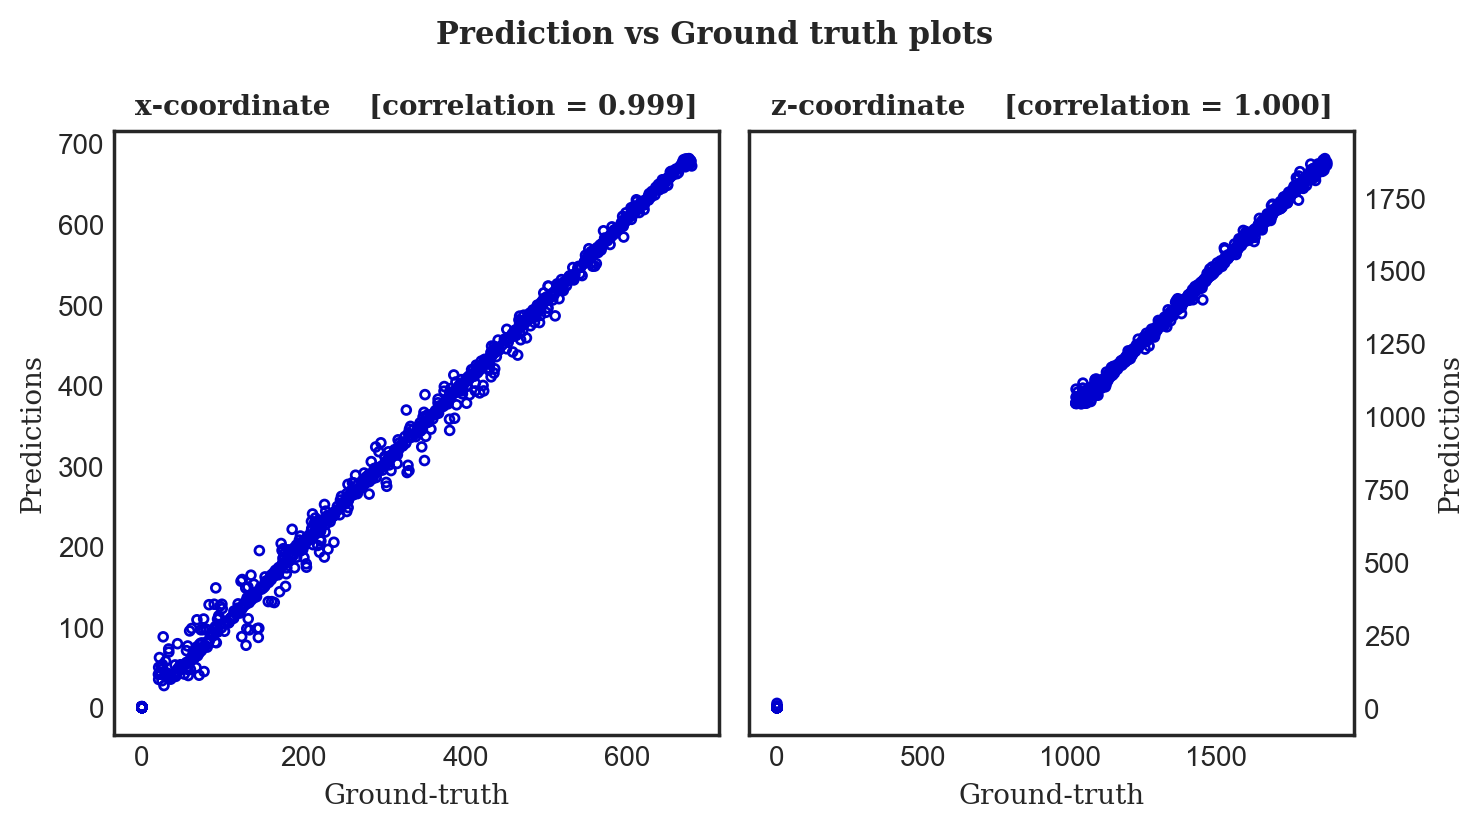

In [34]:
## Plot predicted vs ground-truth values: Include noise samples
fig = plt.figure(figsize=(8,4), dpi=200)
gs  = gridspec.GridSpec(1,2, width_ratios=[1,1], hspace=0.05, wspace=0.05)
fig.suptitle('Prediction vs Ground truth plots', fontname='serif', fontsize=11, fontweight='bold', y=1.02)

xcorcoef = np.corrcoef(y_tests[:,0], preds[:,0])
zcorcoef = np.corrcoef(y_tests[:,1], preds[:,1])

# Plot x Coordinates
ax0  = plt.subplot(gs[0])
ax0.scatter(y_tests[:,0], preds[:,0],facecolors='none', edgecolors='mediumblue', s=10)
ax0.set_title('x-coordinate    [correlation = %.3f]'%xcorcoef[0,1], fontname='serif', fontsize=10, fontweight='bold')
ax0.set_xlabel('Ground-truth', fontname='serif')
ax0.set_ylabel('Predictions', fontname='serif')

# Plot z Coordinates
ax1  = plt.subplot(gs[1])
ax1.scatter(y_tests[:,1], preds[:,1],facecolors='none', edgecolors='mediumblue', s=10)
ax1.set_title('z-coordinate    [correlation = %.3f]'%zcorcoef[0,1], fontname='serif', fontsize=10, fontweight='bold')
ax1.set_xlabel('Ground-truth', fontname='serif')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax1.set_ylabel('Predictions', fontname='serif')

# plt.savefig('./Correlation_with_noise_samples.png', dpi=800)
plt.show()

In [11]:
## Get the Mean Absolute Percentage Error
errors= (preds - y_tests)
msex = np.mean(np.absolute(errors[:,0]))*100/(np.mean(y_tests[:,0]))
msez = np.mean(np.absolute(errors[:,1]))*100/(np.mean(y_tests[:,1]))

print(msex, msez)

2.255138525631878 0.6286762704679786


In [12]:
## Get Standard deviations
stdx, stdz = np.std(errors[:,0]), np.std(errors[:,1])
print(stdx, stdz)

8.006370100693893 7.932767422070724


In [14]:
# Remove noise samples from the plot
mask_ytests, mask_preds = y_tests[:,1]<10, preds[:,1]<20

true_y, true_p = y_tests[~mask_ytests], preds[~mask_preds]
print(true_y.shape, true_p.shape)

(1000, 2) (1000, 2)


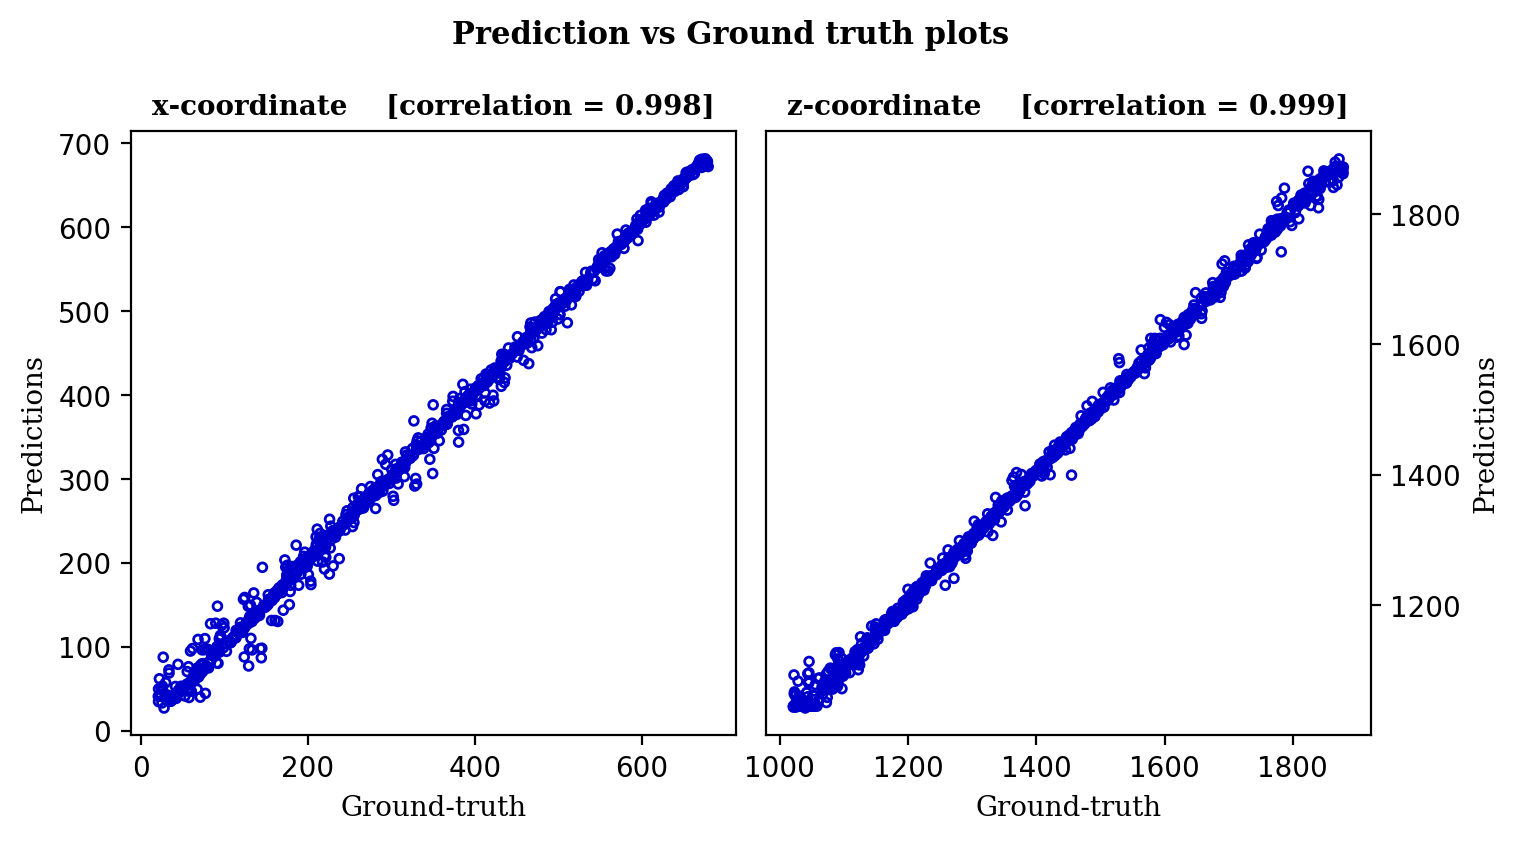

In [16]:
## Plot the predicted vs ground-truth values: Without noise samples
fig = plt.figure(figsize=(8,4), dpi=200)
gs  = gridspec.GridSpec(1,2, width_ratios=[1,1], hspace=0.05, wspace=0.05)
fig.suptitle('Prediction vs Ground truth plots', fontname='serif', fontsize=11, fontweight='bold', y=1.02)

xcorcoef = np.corrcoef(true_y[:,0], true_p[:,0])
zcorcoef = np.corrcoef(true_y[:,1], true_p[:,1])

# Plot x Coordinates
ax0  = plt.subplot(gs[0])
ax0.scatter(true_y[:,0], true_p[:,0],facecolors='none', edgecolors='mediumblue', s=10)
ax0.set_title('x-coordinate    [correlation = %.3f]'%xcorcoef[0,1], fontname='serif', fontsize=10, fontweight='bold')
ax0.set_xlabel('Ground-truth', fontname='serif')
ax0.set_ylabel('Predictions', fontname='serif')

# Plot z Coordinates
ax1  = plt.subplot(gs[1])
ax1.scatter(true_y[:,1], true_p[:,1],facecolors='none', edgecolors='mediumblue', s=10)
ax1.set_title('z-coordinate    [correlation = %.3f]'%zcorcoef[0,1], fontname='serif', fontsize=10, fontweight='bold')
ax1.set_xlabel('Ground-truth', fontname='serif')

ax1.set_ylabel('Predictions', fontname='serif')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')


# plt.savefig('./Correlation_without_noise_samples.png', bbox_inches='tight', dpi=800)

In [17]:
# Error analysis
# y_tests = y_test
error= (true_p - true_y)
maex = np.mean(np.absolute(error[:,0]))*100/(np.mean(true_y[:,0])) 
maez = np.mean(np.absolute(error[:,1]))*100/(np.mean(true_y[:,1]))
print(maex, maez)

2.210623332515251 0.5837726400985696


In [18]:
# Standard deviations
stdx, stdz = np.std(error[:,0]), np.std(error[:,1])
print(stdx, stdz)

11.010607246475242 10.595804557651256


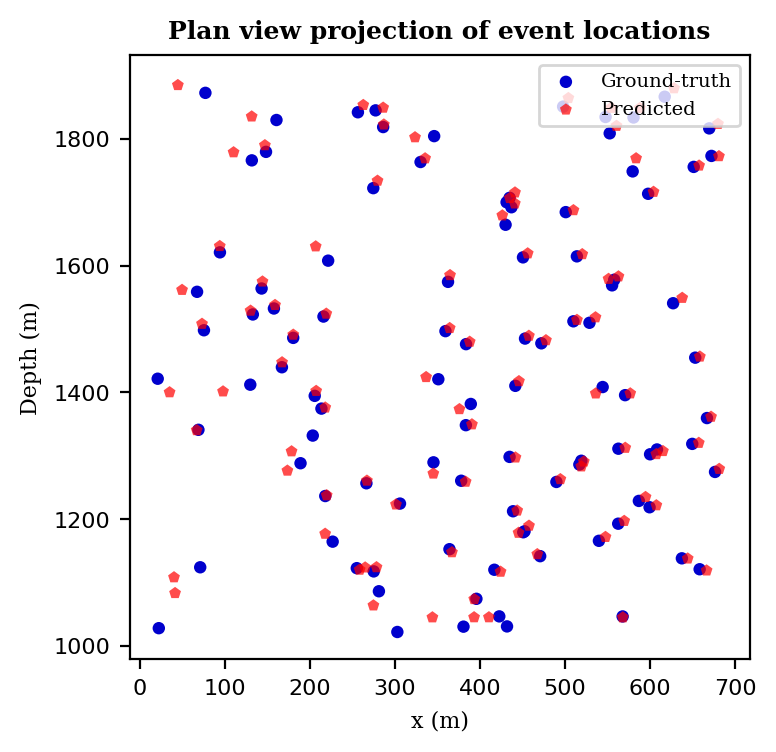

In [20]:
## Plot 2-D section view projection (Scatter plots)
plt.figure(figsize=(4,4), dpi=200)
plt.scatter(true_y[:100,0], true_y[:100,1], marker='o',facecolors='mediumblue', edgecolors='none', s=20, alpha=1,label='Ground-truth')
plt.scatter(true_p[:100,0], true_p[:100,1], marker='p',facecolors='red', edgecolors='none', s=20, alpha=0.7, label='Predicted')
plt.title('Plan view projection of event locations', fontname='serif', fontsize=9, fontweight='bold')
plt.ylabel('Depth (m)', fontname='serif', fontsize=8)
plt.xlabel('x (m)',fontname='serif', fontsize=8)
plt.tick_params(labelsize=8)
plt.legend(loc='upper right', prop={'family':'serif','size':7})
# plt.savefig('./Plan_view_projection.png', bbox_inches='tight', dpi=800)
plt.show()

In [21]:
## Get the residuals
diffz = (true_y[:,1] - true_p[:,1])
diffx = (true_y[:,0] - true_p[:,0])

In [24]:
## This is for the zero line
ze = np.zeros(diffz.shape)
ex = np.linspace(0,700,num=1000)
ez = np.linspace(1000,1900, num=1000)
linex = np.c_[ex, ze]
linez = np.c_[ez, ze]
print(linex.shape, linez.shape)


(1000, 2) (1000, 2)


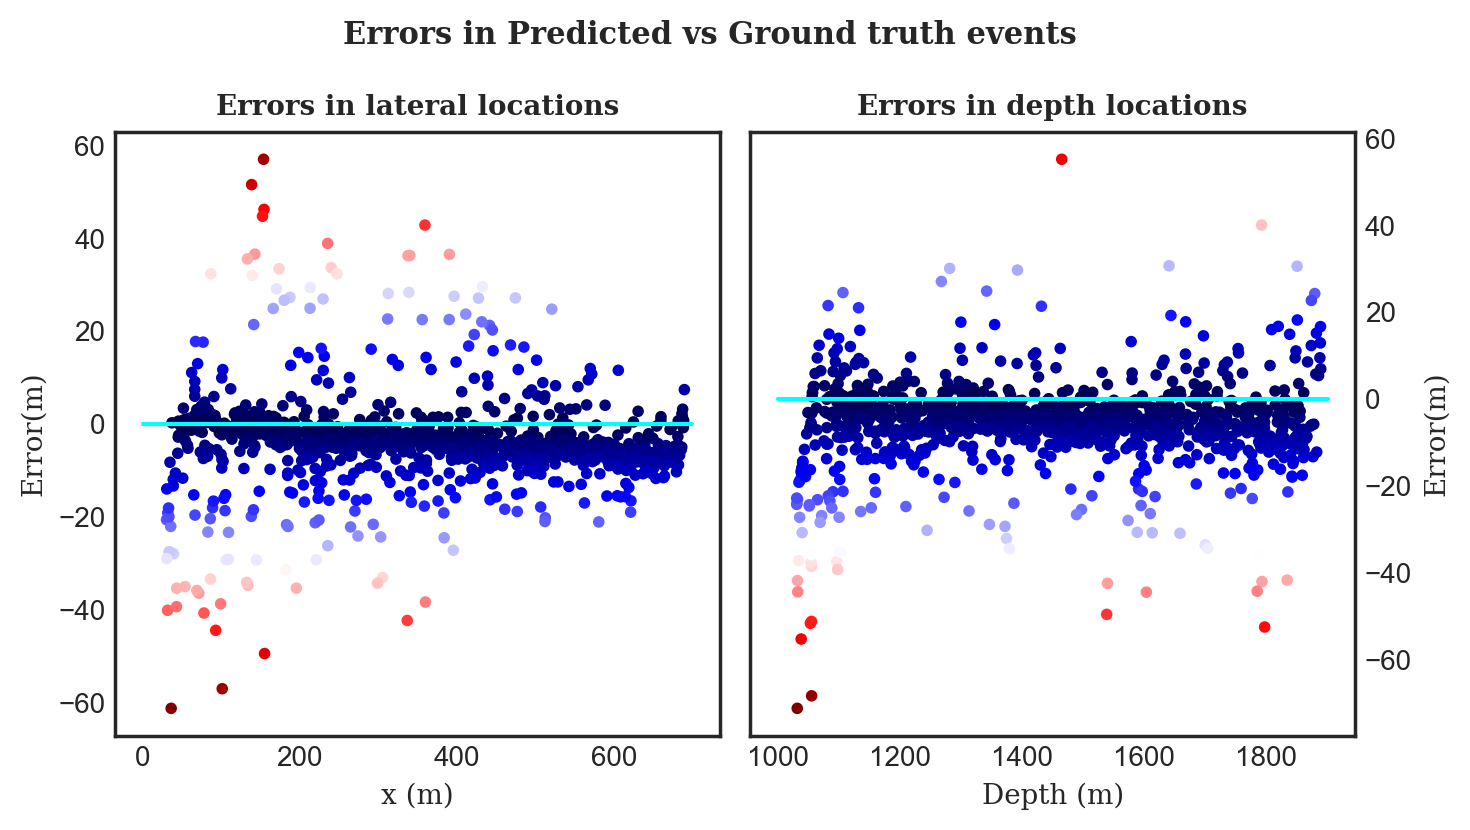

In [33]:
## Plot the residuals
# plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8,4), dpi=200)
gs1  = gridspec.GridSpec(1,2, width_ratios=[1,1], hspace=0.3, wspace=0.05)
fig.suptitle('Errors in Predicted vs Ground truth events ', fontname='serif', fontsize=11, fontweight='bold', y=1.02)

zx, zz = np.exp(abs(diffx)), np.exp(abs(diffz))
normx = matplotlib.colors.LogNorm(vmin=zx.min(), vmax=zx.max())
normz = matplotlib.colors.LogNorm(vmin=zz.min(), vmax=zz.max())

# Plot x Coordinates
ax0  = plt.subplot(gs1[0])
ax0.scatter(true_y[:,0]+10, diffx, c=zx, norm=normx, s=10, cmap='seismic', marker='o')
ax0.plot(linex[:,0], linex[:,1], 'cyan')
ax0.set_title('Errors in lateral locations', fontname='serif', fontsize=10, fontweight='bold')
ax0.set_xlabel('x (m)', fontname='serif')
ax0.set_ylabel('Error(m)', fontname='serif')

# Plot z Coordinates
ax1  = plt.subplot(gs1[1])
ax1.scatter(true_y[:,1]+10, diffz, c=zz, norm=normz, s=10, cmap='seismic', marker='o')
ax1.plot(linez[:,0], linez[:,1], 'cyan')
ax1.set_title('Errors in depth locations', fontname='serif', fontsize=10, fontweight='bold')
ax1.set_xlabel('Depth (m)', fontname='serif')
ax1.set_ylabel('Error(m)', fontname='serif')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')

# plt.savefig('./Errors_plot.png', bbox_inches='tight', dpi=800)
plt.show()